# Heat Fluxes

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
import matplotlib.colors as colors
import seaborn as sns
import seaborn
import pandas as pd
import numpy as np
from importlib import reload
import cartopy.crs as ccrs
import cmocean.cm as cmo
import gsw
import scipy.ndimage as filter
import scipy.interpolate as interpolate

In [2]:
import os
os.chdir('/home.ufs/amf2288/argo-intern/funcs')
import filt_funcs as ff

In [3]:
# Set title size
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 16  # Titles larger

# Set axis label size
plt.rcParams['axes.labelsize'] = 14  # Labels slightly smaller

# Load data (from eddy_diff notebook)

In [4]:
diff_rho = xr.open_dataset('/swot/SUM05/amf2288/diff_rho_3.nc')
K_rho = diff_rho.K_rho

In [5]:
K_rho = K_rho.rename({'rho_grid':'density','lon_c':'lon','lat_c':'lat'})

In [6]:
ds_rho = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_rho_binned_high_res.nc')

In [10]:
%%time
term2_ds = xr.open_dataset('/swot/SUM05/amf2288/var-boxes/term2.nc').load()
term2 = term2_ds.ct_e_z2_filt.rename('term2')
Ke_term3 = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/Ke_term3.nc').rename('term3').load()
ct_m_dx = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/ct_m_dx.nc')
ct_m_dy = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/ct_m_dy.nc')

CPU times: user 27.2 ms, sys: 233 ms, total: 261 ms
Wall time: 258 ms


In [11]:
term3 = np.sqrt(Ke_term3)

In [12]:
%%time
temp_flux_dxdy = K_rho*(term2/term3)

CPU times: user 95.9 ms, sys: 153 ms, total: 249 ms
Wall time: 246 ms


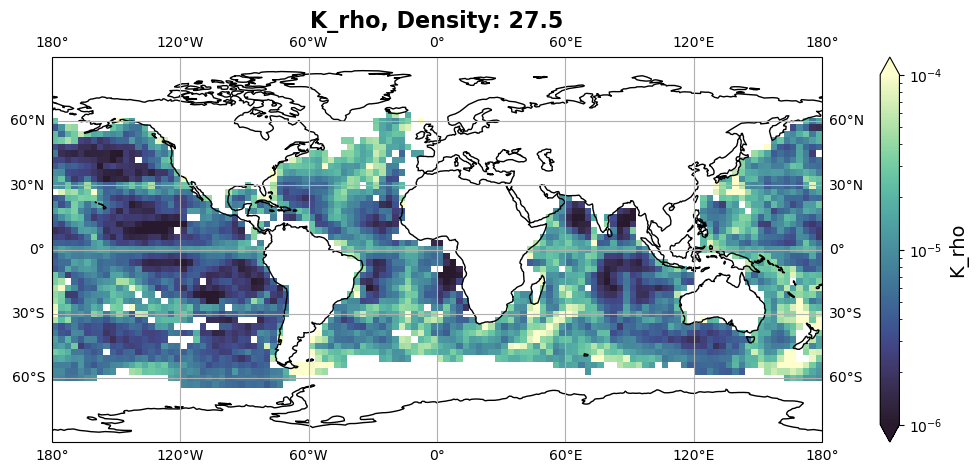

In [13]:
density = 27.5

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
K_rho.sel(density=density, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.deep_r, norm=colors.LogNorm(vmin=1e-6, vmax=1e-4))
ax.set_title('K_rho, Density: {}'.format(np.round(term2.sel(density=density, method='nearest').density.values, 1)))
plt.savefig('../notebooks/argo_clim/figs/K_rho_275.png', bbox_inches='tight')

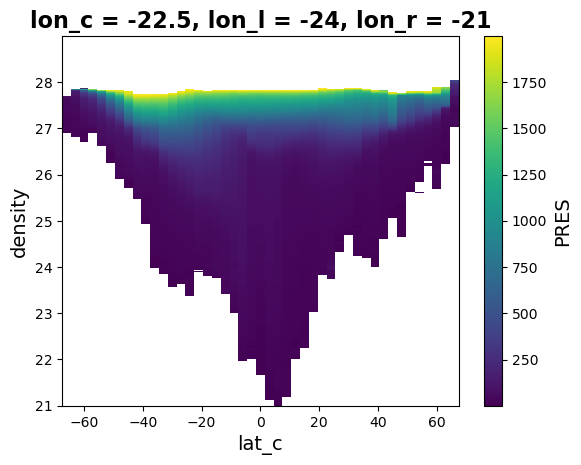

In [15]:
lon=-22.5
ds_rho.PRES.sel(lon_c=lon, method='nearest').plot(x='lat_c', y='density')

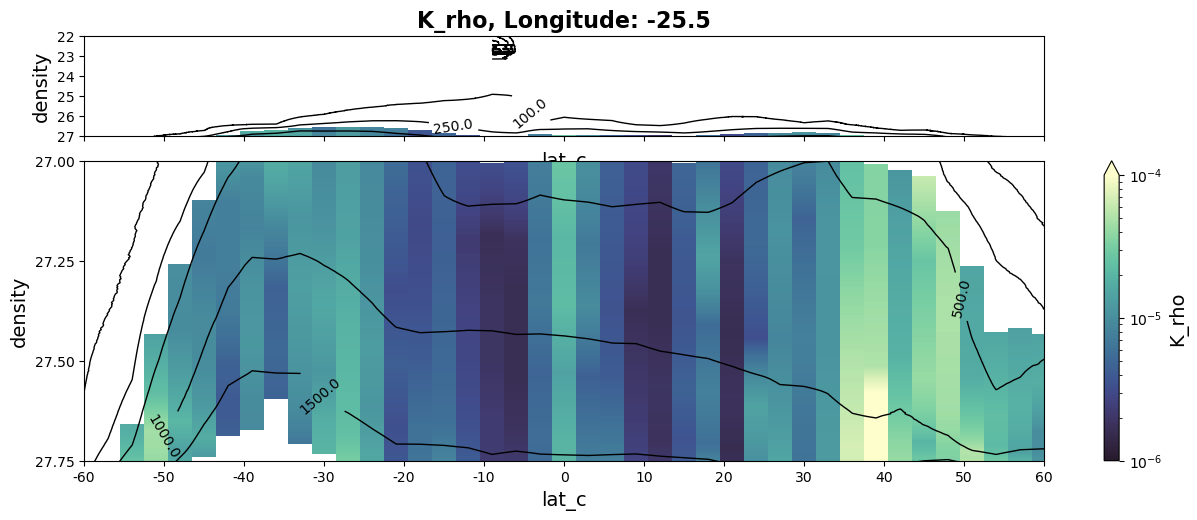

In [22]:
lon = -25

fig = plt.figure(figsize=(15, 5))
top_ax = fig.add_axes([0.1, 0.75, 0.64, 0.2])   # top subplot (1/4 of height)
bottom_ax = fig.add_axes([0.1, 0.1, 0.8, 0.6]) # bottom subplot (3/4 of height)

norm = colors.LogNorm(vmin=1e-6, vmax=1e-4)
levels = [100, 250, 500, 1000, 1500, 2000]

K_rho.sel(lon=lon, method='nearest').plot(ax=top_ax, x='lat', y='density', cmap=cmo.deep_r, norm=norm, add_colorbar=False)
top_ax.set_xticks(np.arange(-70, 71, 10))
top_ax.set_xticklabels([''] * len(top_ax.get_xticks()))
top_ax.set_yticks(np.arange(22, 27.5, 1.0))
top_ax.set_xlabel('')
top_ax.set_ylim(22, 27)
top_ax.set_xlim(-60, 60)
contour = ds_rho.PRES.sel(lon_c=lon, method='nearest').plot.contour(ax=top_ax, x='lat_c', y='density', levels=levels, colors='k', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='k', fontsize=10)
top_ax.invert_yaxis()
top_ax.set_title(f'K_rho, Longitude: {K_rho.sel(lon=lon, method="nearest").lon.values}')

K_rho.sel(lon=lon, method='nearest').plot(ax=bottom_ax, x='lat', y='density', cmap=cmo.deep_r, norm=norm)
bottom_ax.set_xticks(np.arange(-70, 71, 10))
bottom_ax.set_xticklabels(np.arange(-70, 71, 10))
bottom_ax.set_yticks(np.arange(25, 28, 0.25))
bottom_ax.set_ylim(27, 27.75)
bottom_ax.set_xlim(-60, 60)
contour = ds_rho.PRES.sel(lon_c=lon, method='nearest').plot.contour(ax=bottom_ax, x='lat_c', y='density', levels=levels, colors='k', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='k', fontsize=10)
bottom_ax.invert_yaxis()
bottom_ax.set_title('')

plt.savefig('../notebooks/argo_clim/figs/K_rho_275_sect.png', bbox_inches='tight')

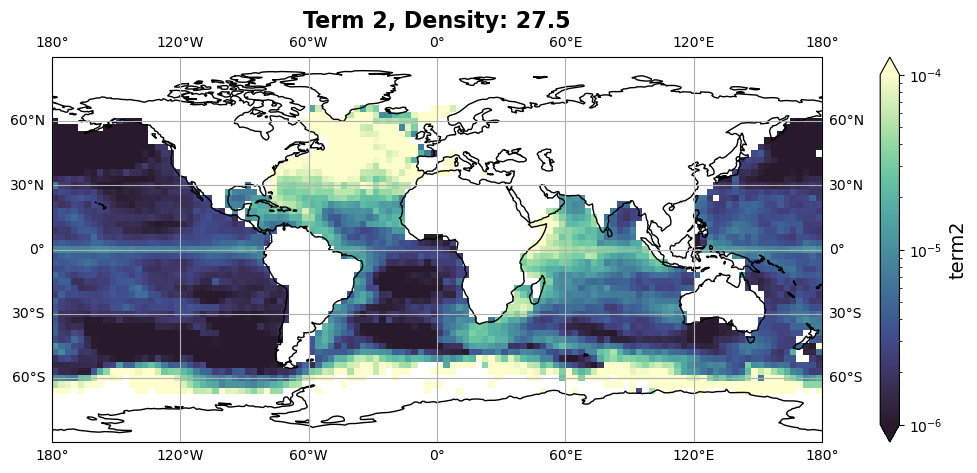

In [24]:
density = 27.5

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
term2.sel(density=density, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.deep_r, norm=colors.LogNorm(vmin=1e-6, vmax=1e-4))
ax.set_title('Term 2, Density: {}'.format(np.round(term2.sel(density=density, method='nearest').density.values, 1)))
plt.savefig('../notebooks/argo_clim/figs/term2_275.png', bbox_inches='tight')

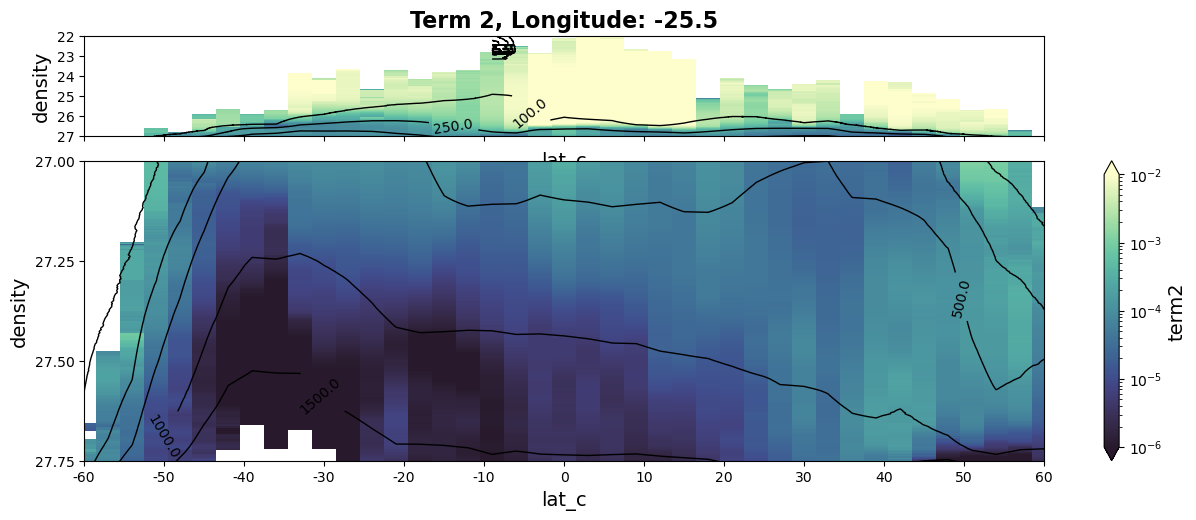

In [26]:
lon = -25

fig = plt.figure(figsize=(15, 5))
top_ax = fig.add_axes([0.1, 0.75, 0.64, 0.2])   # top subplot (1/4 of height)
bottom_ax = fig.add_axes([0.1, 0.1, 0.8, 0.6]) # bottom subplot (3/4 of height)

norm = colors.LogNorm(vmin=1e-6, vmax=1e-2)
levels = [100, 250, 500, 1000, 1500, 2000]

term2.sel(lon=lon, method='nearest').plot(ax=top_ax, x='lat', y='density', cmap=cmo.deep_r, norm=norm, add_colorbar=False)
top_ax.set_xticks(np.arange(-70, 71, 10))
top_ax.set_xticklabels([''] * len(top_ax.get_xticks()))
top_ax.set_yticks(np.arange(27.0, 21.5, -1.0))
top_ax.set_xlabel('')
top_ax.set_ylim(27, 22)
top_ax.set_xlim(-60, 60)
contour = ds_rho.PRES.sel(lon_c=lon, method='nearest').plot.contour(ax=top_ax, x='lat_c', y='density', levels=levels, colors='k', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='k', fontsize=10)
top_ax.invert_yaxis()
top_ax.set_title(f'Term 2, Longitude: {K_rho.sel(lon=lon, method="nearest").lon.values}')

term2.sel(lon=lon, method='nearest').plot(ax=bottom_ax, x='lat', y='density', cmap=cmo.deep_r, norm=norm)
bottom_ax.set_xticks(np.arange(-70, 71, 10))
bottom_ax.set_xticklabels(np.arange(-70, 71, 10))
bottom_ax.set_yticks(np.arange(27.75, 25.5, -0.25))
bottom_ax.set_ylim(27.75, 27)
bottom_ax.set_xlim(-60, 60)
contour = ds_rho.PRES.sel(lon_c=lon, method='nearest').plot.contour(ax=bottom_ax, x='lat_c', y='density', levels=levels, colors='k', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='k', fontsize=10)
bottom_ax.invert_yaxis()
bottom_ax.set_title('')

plt.savefig('../notebooks/argo_clim/figs/term2_275_sect.png', bbox_inches='tight')

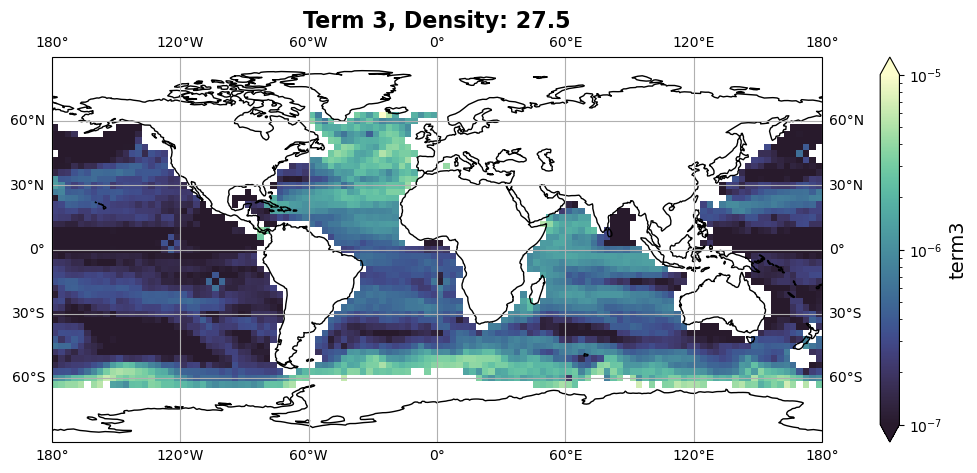

In [43]:
density = 27.5

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
term3.sel(density=density, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.deep_r,  norm=colors.LogNorm(vmin=1e-7, vmax=1e-5))
#ax.set_title('sqrt(dT/dx**2 + dT/dy**2), density: {}'.format(np.round(temp_flux_dxdy.sel(density=density, method='nearest').density.values, 1)))
ax.set_title('Term 3, Density: {}'.format(np.round(term3.sel(density=density, method='nearest').density.values, 1)))
plt.savefig('../notebooks/argo_clim/figs/term3_NOSQUARE_275.png', bbox_inches='tight')

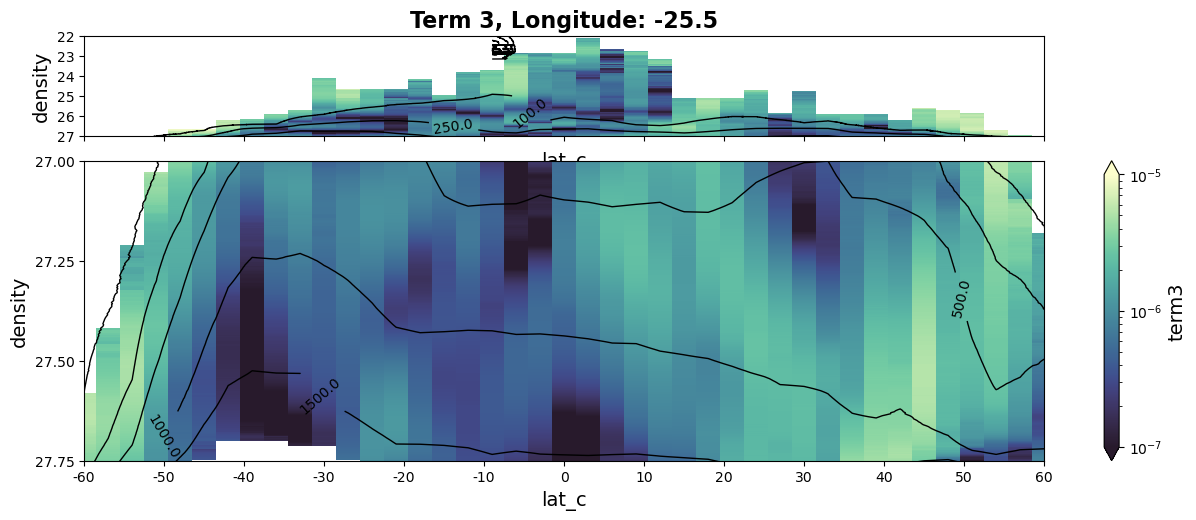

In [45]:
lon = -25

fig = plt.figure(figsize=(15, 5))
top_ax = fig.add_axes([0.1, 0.75, 0.64, 0.2])   # top subplot (1/4 of height)
bottom_ax = fig.add_axes([0.1, 0.1, 0.8, 0.6]) # bottom subplot (3/4 of height)

norm = colors.LogNorm(vmin=1e-7, vmax=1e-5)
levels = [100, 250, 500, 1000, 1500, 2000]

term3.sel(lon=lon, method='nearest').plot(ax=top_ax, x='lat', y='density', cmap=cmo.deep_r, norm=norm, add_colorbar=False)
top_ax.set_xticks(np.arange(-70, 71, 10))
top_ax.set_xticklabels([''] * len(top_ax.get_xticks()))
top_ax.set_yticks(np.arange(27.0, 21.5, -1.0))
top_ax.set_xlabel('')
top_ax.set_ylim(27, 22)
top_ax.set_xlim(-60, 60)
contour = ds_rho.PRES.sel(lon_c=lon, method='nearest').plot.contour(ax=top_ax, x='lat_c', y='density', levels=levels, colors='k', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='k', fontsize=10)
top_ax.invert_yaxis()
top_ax.set_title(f'Term 3, Longitude: {K_rho.sel(lon=lon, method="nearest").lon.values}')

term3.sel(lon=lon, method='nearest').plot(ax=bottom_ax, x='lat', y='density', cmap=cmo.deep_r, norm=norm)
bottom_ax.set_xticks(np.arange(-70, 71, 10))
bottom_ax.set_xticklabels(np.arange(-70, 71, 10))
bottom_ax.set_yticks(np.arange(27.75, 25.5, -0.25))
bottom_ax.set_ylim(27.75, 27)
bottom_ax.set_xlim(-60, 60)
contour = ds_rho.PRES.sel(lon_c=lon, method='nearest').plot.contour(ax=bottom_ax, x='lat_c', y='density', levels=levels, colors='k', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='k', fontsize=10)
bottom_ax.invert_yaxis()
bottom_ax.set_title('')

plt.savefig('../notebooks/argo_clim/figs/term3_275_sect.png', bbox_inches='tight')

CPU times: user 693 ms, sys: 33 ms, total: 726 ms
Wall time: 723 ms


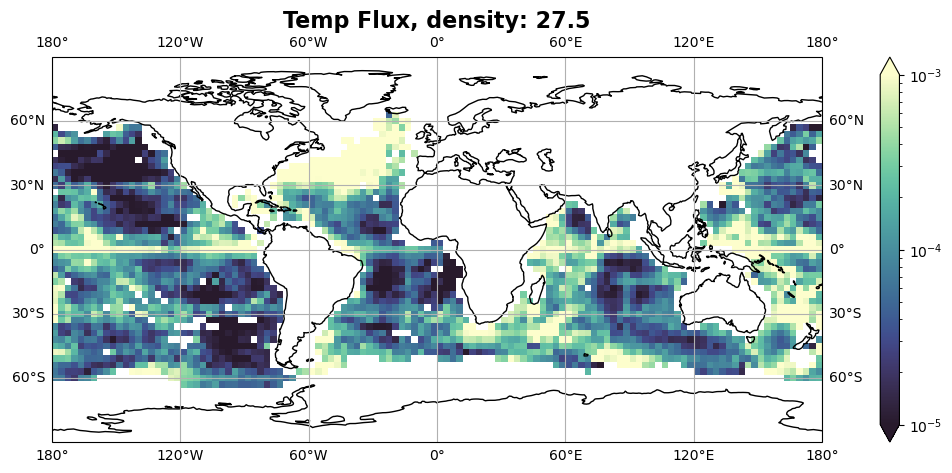

In [51]:
%%time

density = 27.5

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
temp_flux_dxdy.sel(density=density, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.deep_r, norm=colors.LogNorm(vmin=1e-5, vmax=1e-3))
plt.title('Temp Flux, density: {}'.format(np.round(temp_flux_dxdy.sel(density=density, method='nearest').density.values, 1)))
plt.savefig('../notebooks/argo_clim/figs/temp_flux_275.png', bbox_inches='tight')

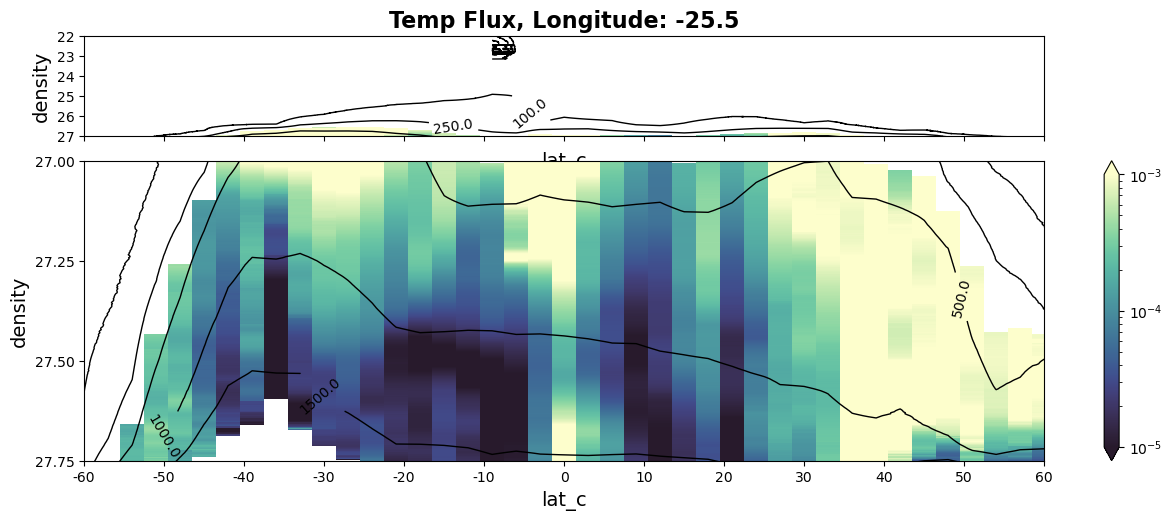

In [54]:
lon = -25

fig = plt.figure(figsize=(15, 5))
top_ax = fig.add_axes([0.1, 0.75, 0.64, 0.2])   # top subplot (1/4 of height)
bottom_ax = fig.add_axes([0.1, 0.1, 0.8, 0.6]) # bottom subplot (3/4 of height)

norm = colors.LogNorm(vmin=1e-5, vmax=1e-3)
levels = [100, 250, 500, 1000, 1500, 2000]

temp_flux_dxdy.sel(lon=lon, method='nearest').plot(ax=top_ax, x='lat', y='density', cmap=cmo.deep_r, norm=norm, add_colorbar=False)
top_ax.set_xticks(np.arange(-70, 71, 10))
top_ax.set_xticklabels([''] * len(top_ax.get_xticks()))
top_ax.set_yticks(np.arange(27.0, 21.5, -1.0))
top_ax.set_xlabel('')
top_ax.set_ylim(27, 22)
top_ax.set_xlim(-60, 60)
contour = ds_rho.PRES.sel(lon_c=lon, method='nearest').plot.contour(ax=top_ax, x='lat_c', y='density', levels=levels, colors='k', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='k', fontsize=10)
top_ax.invert_yaxis()
top_ax.set_title(f'Temp Flux, Longitude: {K_rho.sel(lon=lon, method="nearest").lon.values}')

temp_flux_dxdy.sel(lon=lon, method='nearest').plot(ax=bottom_ax, x='lat', y='density', cmap=cmo.deep_r, norm=norm)
bottom_ax.set_xticks(np.arange(-70, 71, 10))
bottom_ax.set_xticklabels(np.arange(-70, 71, 10))
bottom_ax.set_yticks(np.arange(27.75, 25.5, -0.25))
bottom_ax.set_ylim(27.75, 27)
bottom_ax.set_xlim(-60, 60)
contour = ds_rho.PRES.sel(lon_c=lon, method='nearest').plot.contour(ax=bottom_ax, x='lat_c', y='density', levels=levels, colors='k', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='k', fontsize=10)
bottom_ax.invert_yaxis()
bottom_ax.set_title('')

plt.savefig('../notebooks/argo_clim/figs/temp_flux_275_sect.png', bbox_inches='tight')

In [55]:
density = temp_flux_dxdy.density + 1000
heat_flux = temp_flux_dxdy*density*4000

CPU times: user 974 ms, sys: 73.7 ms, total: 1.05 s
Wall time: 1.04 s


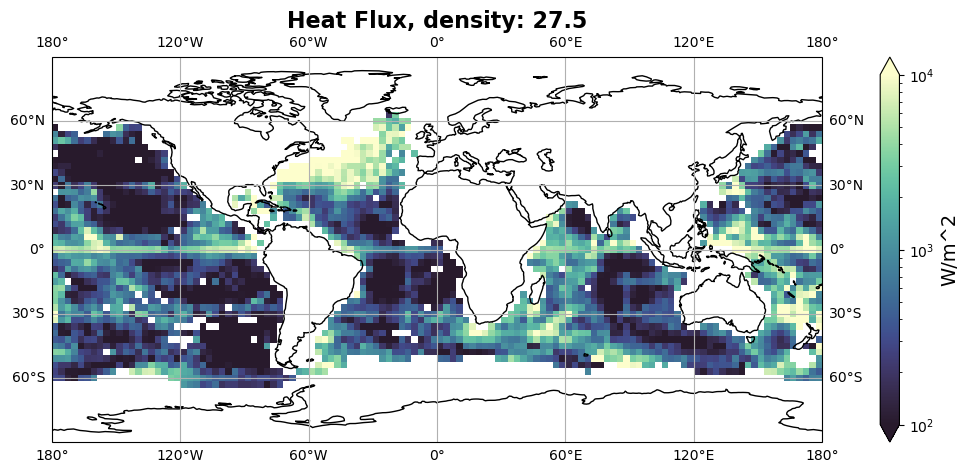

In [59]:
%%time

density = 27.5

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
heat_flux.sel(density=density, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.deep_r, norm=colors.LogNorm(vmin=1e2, vmax=1e4), cbar_kwargs={'label': 'W/m^2'})
plt.title('Heat Flux, density: {}'.format(np.round(temp_flux_dxdy.sel(density=density, method='nearest').density.values, 1)))
plt.savefig('../notebooks/argo_clim/figs/heat_flux_275.png', bbox_inches='tight')

heat flux = $\widetilde{u}\widetilde{T} \frac{^\circ C m}{s}*\rho_0 \frac{kg}{m^3}*C_p \frac{J}{kg ^\circ C}$

heat flux = $2570 \frac{W}{m^2}$

where $\rho_0 = density + 1000$,  $C_p = 4000 \frac{J}{kg ^\circ C}$



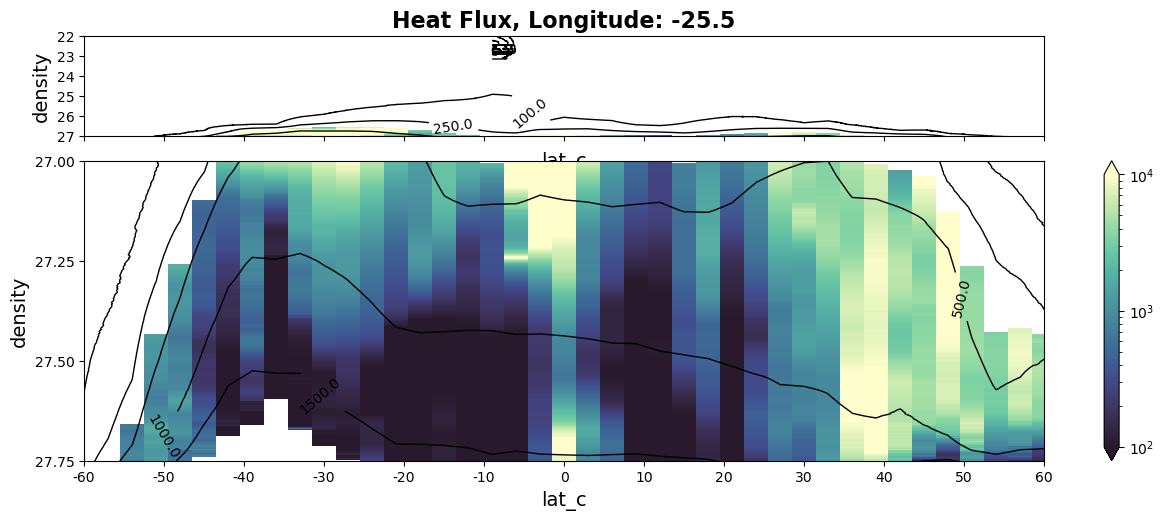

In [60]:
lon = -25

fig = plt.figure(figsize=(15, 5))
top_ax = fig.add_axes([0.1, 0.75, 0.64, 0.2])   # top subplot (1/4 of height)
bottom_ax = fig.add_axes([0.1, 0.1, 0.8, 0.6]) # bottom subplot (3/4 of height)

norm = colors.LogNorm(vmin=1e2, vmax=1e4)
levels = [100, 250, 500, 1000, 1500, 2000]

heat_flux.sel(lon=lon, method='nearest').plot(ax=top_ax, x='lat', y='density', cmap=cmo.deep_r, norm=norm, add_colorbar=False)
top_ax.set_xticks(np.arange(-70, 71, 10))
top_ax.set_xticklabels([''] * len(top_ax.get_xticks()))
top_ax.set_yticks(np.arange(27.0, 21.5, -1.0))
top_ax.set_xlabel('')
top_ax.set_ylim(27, 22)
top_ax.set_xlim(-60, 60)
contour = ds_rho.PRES.sel(lon_c=lon, method='nearest').plot.contour(ax=top_ax, x='lat_c', y='density', levels=levels, colors='k', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='k', fontsize=10)
top_ax.invert_yaxis()
top_ax.set_title(f'Heat Flux, Longitude: {K_rho.sel(lon=lon, method="nearest").lon.values}')

heat_flux.sel(lon=lon, method='nearest').plot(ax=bottom_ax, x='lat', y='density', cmap=cmo.deep_r, norm=norm)
bottom_ax.set_xticks(np.arange(-70, 71, 10))
bottom_ax.set_xticklabels(np.arange(-70, 71, 10))
bottom_ax.set_yticks(np.arange(27.75, 25.5, -0.25))
bottom_ax.set_ylim(27.75, 27)
bottom_ax.set_xlim(-60, 60)
contour = ds_rho.PRES.sel(lon_c=lon, method='nearest').plot.contour(ax=bottom_ax, x='lat_c', y='density', levels=levels, colors='k', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='k', fontsize=10)
bottom_ax.invert_yaxis()
bottom_ax.set_title('')

plt.savefig('../notebooks/argo_clim/figs/heat_flux_275_sect.png', bbox_inches='tight')

# Flux Method 2 (Using $K_e$)

In [14]:
K_rho = xr.open_dataset('/swot/SUM05/amf2288/var-boxes/K_rho_3dx.nc').K_filt_3dx

In [15]:
term2_ds = xr.open_dataset('/swot/SUM05/amf2288/var-boxes/term2.nc').load()
term2 = term2_ds.ct_e_z2_filt.rename('term2')
term3 = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/Ke_term3.nc').rename('term3').load()

In [18]:
K_e = K_rho*term2/term3

In [21]:
dCT_dx = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/ct_m_dx.nc')
dCT_dy = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/ct_m_dy.nc')

In [26]:
F_CT_x = K_e*dCT_dx
F_CT_y = K_e*dCT_dy
F_CT_xy = np.sqrt(F_CT_x**2 + F_CT_y**2)

Text(0.5, 1.0, 'dCT_dx, depth-averaged')

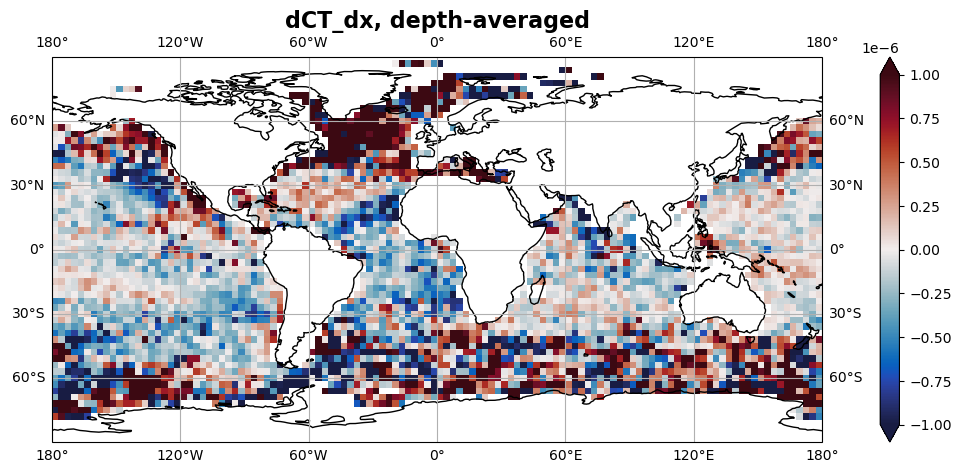

In [37]:
ds = dCT_dx
title= 'dCT_dx'
cmap, norm = cmo.balance, colors.Normalize(vmin=-0.000001, vmax=0.000001)

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds.mean('density').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.set_title(f'{title}, depth-averaged')

In [46]:
temp_flux_dxdy = K_rho*(term2/np.sqrt(term3))

Text(0.5, 1.0, 'Temp Flux, depth-averaged')

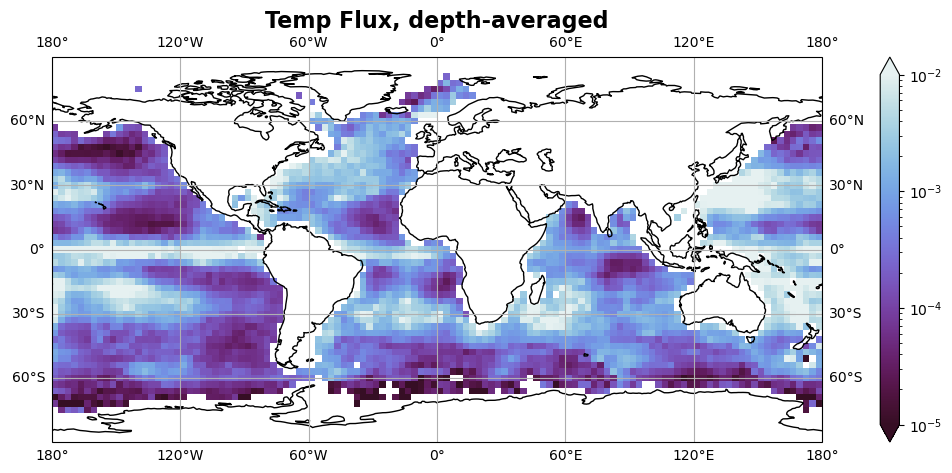

In [44]:
ds = F_CT_xy
title= 'Temp Flux'
cmap, norm = cmo.dense_r, colors.LogNorm(vmin=1e-5, vmax=1e-2)

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds.mean('density').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.set_title(f'{title}, depth-averaged')

Text(0.5, 1.0, 'Temp Flux, depth-averaged')

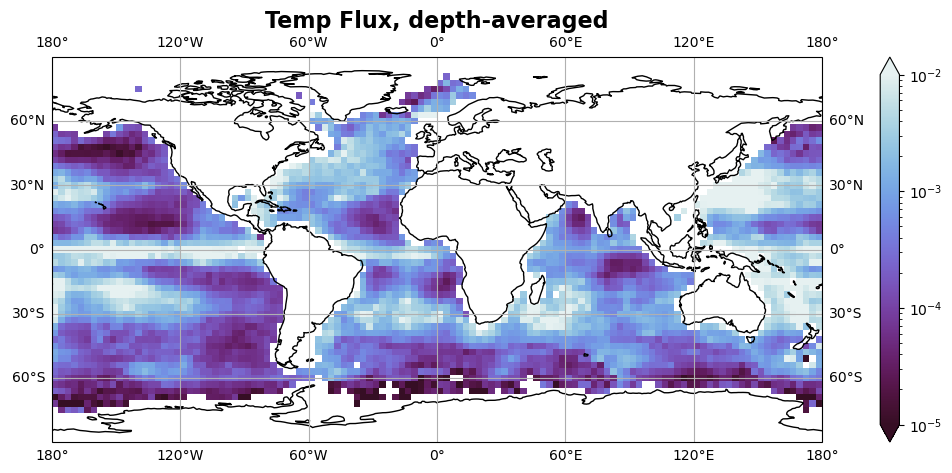

In [47]:
ds = temp_flux_dxdy
title= 'Temp Flux'
cmap, norm = cmo.dense_r, colors.LogNorm(vmin=1e-5, vmax=1e-2)

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds.mean('density').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.set_title(f'{title}, depth-averaged')

Text(0.5, 1.0, 'Temp Flux, depth-averaged')

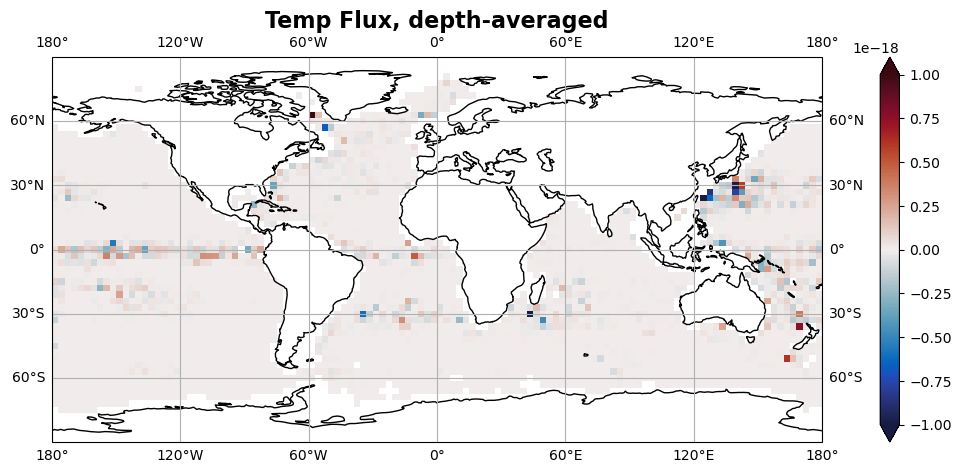

In [57]:
ds = (temp_flux_dxdy - F_CT_xy)
title= 'Temp Flux'
cmap, norm = cmo.balance, colors.Normalize(vmin=-0.000000000000000001, vmax=0.000000000000000001)

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds.mean('density').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.set_title(f'{title}, depth-averaged')